## Problem 1

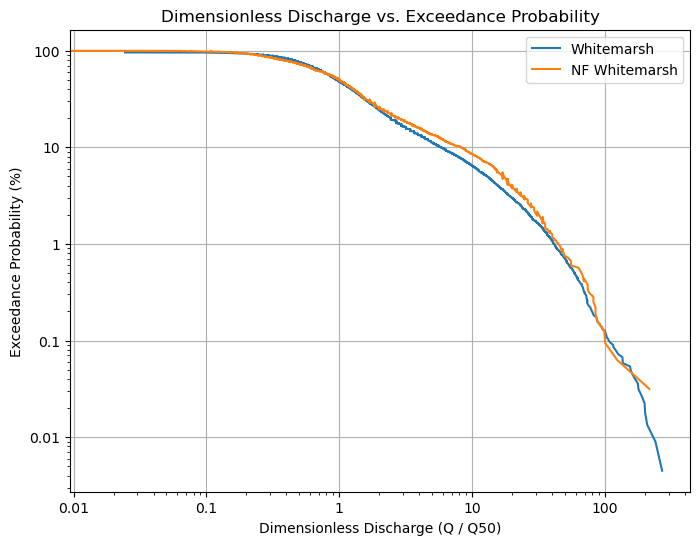

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the Excel file
excel_path = r"C:\Users\adunw\OneDrive - Colostate\Fort Collins\Courses\Spring 2025\CIVE 613 - River Restoration\HW 2\Q1 Whitemarsh Run USGS  01585100.xlsx"

# Names of the sheets
sheet1 = "Whitemarsh"
sheet2 = "NF Whitemarsh"

def prepare_data(df, discharge_col="Discharge (cfs)"):
    # Compute the median discharge (Q50)
    q50 = df[discharge_col].median()
    
    # Compute dimensionless discharge
    df["Dimensionless_Q"] = df[discharge_col] / q50
    
    # Sort by discharge (descending) to assign ranks
    df_sorted = df.sort_values(by=discharge_col, ascending=False).reset_index(drop=True)
    n = len(df_sorted)
    
    # rank = 1 to n, so exceedance probability = rank/(n+1)
    df_sorted["Rank"] = df_sorted.index + 1
    df_sorted["Exceedance_Pro"] = df_sorted["Rank"] / (n + 1) *100
    
    # For plotting Dimensionless_Q on x-axis (ascending order),
    # re-sort by dimensionless discharge
    df_sorted = df_sorted.sort_values(by="Dimensionless_Q").reset_index(drop=True)
    return df_sorted

# Read each sheet
df_whitemarsh = pd.read_excel(excel_path, sheet_name=sheet1)
df_nf_whitemarsh = pd.read_excel(excel_path, sheet_name=sheet2)

# Prepare data for each sheet
whitemarsh_prepared = prepare_data(df_whitemarsh)
nf_whitemarsh_prepared = prepare_data(df_nf_whitemarsh)

# Plot both datasets
plt.figure(figsize=(8, 6))

plt.plot(
    whitemarsh_prepared["Dimensionless_Q"],
    whitemarsh_prepared["Exceedance_Pro"],
    linestyle='-',
    label=sheet1
)
plt.plot(
    nf_whitemarsh_prepared["Dimensionless_Q"],
    nf_whitemarsh_prepared["Exceedance_Pro"],
    linestyle='-',
    label=sheet2
)

#Plot on a log scale
plt.yscale("log")
plt.xscale("log")
#Show y axis in normal number nnotation not scientific
import matplotlib.ticker as mticker

ax = plt.gca()
# Convert ot general number format from scientific notation
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, pos: '{:g}'.format(x)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: '{:g}'.format(y)))


plt.xlabel("Dimensionless Discharge (Q / Q50)")
plt.ylabel("Exceedance Probability (%)")
plt.title("Dimensionless Discharge vs. Exceedance Probability")
plt.legend()
plt.grid(True)
plt.show()


### Problem 2
 Use the USGS gage at Red Cliff, CO on the Eagle River to generate three estimates of the
 post-1944 Q1.5 at the following seven locations in and around the Camp Hale restoration
 site. Assume that peak flow scales with the Q2 exponents provided by the USGS Flood
 Regression equations for Colorado presented by USGS in Jennings et al. (1994), Vaill (2000),
 and Capesius and Stephens (2009). Estimate an interdecile flow duration curve for
 Above Yoder. 
 
| Location         | Basin Slope | Drainage Area (sq. mi.) |
|------------------|-------------|-------------------------|
| Red Cliff        | 0.3         | 70                      |
| Pando            | 0.29        | 66.4                    |
| Above Yoder      | 0.28        | 47.7                    |
| South Fork Eagle | 0.24        | 18.8                    |
| East Fork Eagle  | 0.31        | 24.6                    |
| Resolution Creek | 0.37        | 11.8                    |
| Yoder            | 0.25        | 3.8                     |


Jennings et al. (1994)
$$ Q_2 = 74.3A^{0.693}S^{0.894} $$


Vail, 2000:
 $$ Q_2 = 11.0 (A)^{0.663} (S + 1.0)^{3.465} $$

Capesius and Stephens (2009):

$$ Q_2 = 10^{-2.05}A^{0.78}S^{0.17}P^{2.10} $$

where P = 30 inches according to Prism (Prism is source for P, Mean annual precipitation, in inches according to Table 2)

Red Cliff Q1.5: 196.65 cfs, Q2: 262.00 cfs, Ratio (Q2/Q1.5): 1.332

Estimated Q1.5 values for each location:
           Location  Drainage_A_sqmi  Basin_Slope  Q1.5_Jennings (cfs)  \
0         Red Cliff             70.0         0.30           361.057524   
1             Pando             66.4         0.29           337.694001   
2       Above Yoder             47.7         0.28           260.225333   
3  South Fork Eagle             18.8         0.24           118.926133   
4   East Fork Eagle             24.6         0.31           180.124355   
5  Resolution Creek             11.8         0.37           126.812957   
6             Yoder              3.8         0.25            40.731036   

   Q1.5_Vaill (cfs)  Q1.5_Capesius (cfs)  
0        342.684644           261.949890  
1        322.160070           249.936623  
2        251.837940           191.951865  
3        121.689672            90.450333  
4        175.920294           116.517728  
5        126.233744            67.700737

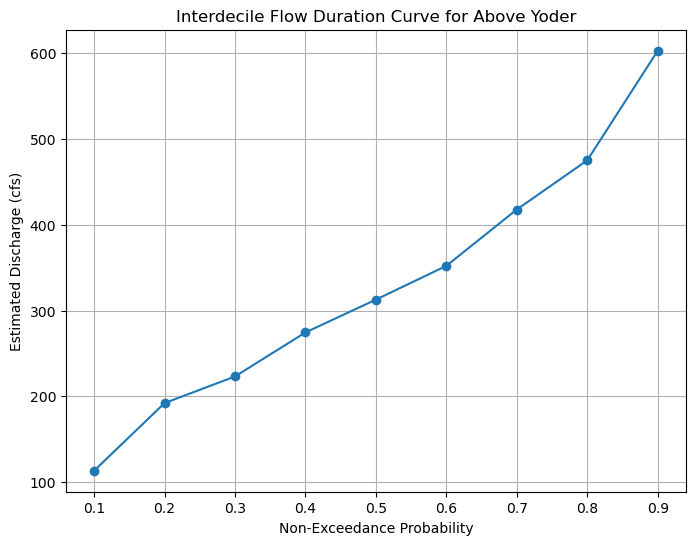

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Step 1. Read the USGS gage data from Excel.
# -------------------------------
excel_path = r"C:\Users\adunw\OneDrive - Colostate\Fort Collins\Courses\Spring 2025\CIVE 613 - River Restoration\HW 2\Q2 Eagle River at Red Cliff CO.xlsx"
df = pd.read_excel(excel_path)

# Ensure the datetime column is parsed as datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Convert the Discharge column to numeric (coercing non-numeric values to NaN)
df['Discharge (cfs)'] = pd.to_numeric(df['Discharge (cfs)'], errors='coerce')
# Optionally drop rows with missing discharge values
df = df.dropna(subset=['Discharge (cfs)'])

# -------------------------------
# Step 2. Compute annual maximum discharge series.
# -------------------------------
df['year'] = df['datetime'].dt.year
annual_max = df.groupby('year')['Discharge (cfs)'].max()

if len(annual_max) < 3:
    print("Warning: The annual maximum series has fewer than 3 values; frequency analysis may be unreliable.")


# -------------------------------
# Step 3. Estimate Q1.5 and Q2 from the annual maxima.
# -------------------------------
# For a return period T, the non-exceedance probability is 1 - 1/T.
# Thus for T = 1.5 years, probability = 1 - 1/1.5 = 0.3333;
# and for T = 2 years, probability = 1 - 1/2 = 0.5.
q1_5 = np.percentile(annual_max, 33.33)
q2 = np.percentile(annual_max, 50)

# Compute ratio Q2 / Q1.5
ratio = q2 / q1_5
print(f"Red Cliff Q1.5: {q1_5:.2f} cfs, Q2: {q2:.2f} cfs, Ratio (Q2/Q1.5): {ratio:.3f}")

# -------------------------------
# Step 4. Define regression functions to compute Q2.
# -------------------------------
def q2_jennings(A, S):
    """Jennings et al. (1994) regression equation for Q2."""
    return 74.3 * (A ** 0.693) * (S ** 0.894)

def q2_vaill(A, S):
    """Vail (2000) regression equation for Q2."""
    return 11.0 * (A ** 0.663) * ((S + 1.0) ** 3.465)

def q2_capesius(A, S, P=35):
    """Capesius and Stephens (2009) regression equation for Q2.
       P is mean annual precipitation in inches (default 35)."""
    return (10 ** (-2.05)) * (A ** 0.78) * (S ** 0.17) * (P ** 2.10)

# -------------------------------
# Step 5. Set up site characteristics for the seven locations.
# -------------------------------
sites = pd.DataFrame({
    'Location': ['Red Cliff', 'Pando', 'Above Yoder', 'South Fork Eagle',
                 'East Fork Eagle', 'Resolution Creek', 'Yoder'],
    'Drainage_A_sqmi': [70, 66.4, 47.7, 18.8, 24.6, 11.8, 3.8],
    'Basin_Slope': [0.3, 0.29, 0.28, 0.24, 0.31, 0.37, 0.25]
})

# -------------------------------
# Step 6. Compute Q2 using each regression and then estimate Q1.5 using the ratio from Red Cliff.
# -------------------------------
q1_5_j = []
q1_5_v = []
q1_5_c = []

for idx, row in sites.iterrows():
    A = row['Drainage_A_sqmi']
    S = row['Basin_Slope']
    
    # Compute Q2 estimates for each regression
    Q2_j = q2_jennings(A, S)
    Q2_v = q2_vaill(A, S)
    Q2_c = q2_capesius(A, S)
    
    # Convert to Q1.5 by dividing by the Red Cliff ratio
    q1_5_j.append(Q2_j / ratio)
    q1_5_v.append(Q2_v / ratio)
    q1_5_c.append(Q2_c / ratio)

# Add the Q1.5 estimates to the DataFrame
sites['Q1.5_Jennings (cfs)'] = q1_5_j
sites['Q1.5_Vaill (cfs)'] = q1_5_v
sites['Q1.5_Capesius (cfs)'] = q1_5_c

print("\nEstimated Q1.5 values for each location:")
print(sites)

# -------------------------------
# Step 7. For Above Yoder, average the three Q1.5 estimates to use as the index flood.
# -------------------------------
above_yoder = sites[sites['Location'] == 'Above Yoder']
if not above_yoder.empty:
    Q1_5_estimates = above_yoder[['Q1.5_Jennings (cfs)', 'Q1.5_Vaill (cfs)', 'Q1.5_Capesius (cfs)']].iloc[0]
    Q1_5_above_yoder = Q1_5_estimates.mean()
    print(f"\nAbove Yoder average Q1.5 estimate: {Q1_5_above_yoder:.2f} cfs")
else:
    raise ValueError("Above Yoder site not found in the site table.")

# -------------------------------
# Step 8. Compute the dimensionless (interdecile) flow duration curve from Red Cliff data.
# -------------------------------
# We use the annual maximum series to compute quantiles between 10% and 90%.
p_vals = np.linspace(0.10, 0.90, 9)  # non-exceedance probabilities
# Compute discharge values at these probabilities (in cfs)
Q_vals_red = np.percentile(annual_max, p_vals * 100)
# Form the dimensionless factors relative to Q1.5 from Red Cliff
dim_factors = Q_vals_red / q1_5

# Now, for Above Yoder, scale the dimensionless FDC by the Above Yoder Q1.5 estimate
Q_vals_above = dim_factors * Q1_5_above_yoder

# -------------------------------
# Step 9. Plot the interdecile flow duration curve for Above Yoder.
# -------------------------------
plt.figure(figsize=(8, 6))
plt.plot(p_vals, Q_vals_above, marker='o', linestyle='-')
plt.xlabel('Non-Exceedance Probability')
plt.ylabel('Estimated Discharge (cfs)')
plt.title('Interdecile Flow Duration Curve for Above Yoder')
plt.grid(True)
plt.show()


**How do these values compare with estimates of bankfull discharge based on Segura and Pitlick (2010)?**

As shown in the plot below, there is a wide range of variability to the bankfull discharge of Colorado streams reported in Segura and Pitlick (2010). Two high outlier values were removed from the bankfull discharge estiamtes to improve the clarity of the plot. 

The estimates from the three methods mainly line up with each other and with the Segura and Pitlick (2010) estimates. The Segura and Pitlick (2010) estimates show a wider range of variability than our measured sites, which make sense because they are located all around the mountainous region of colorado, whereas our sites are more concentrated.

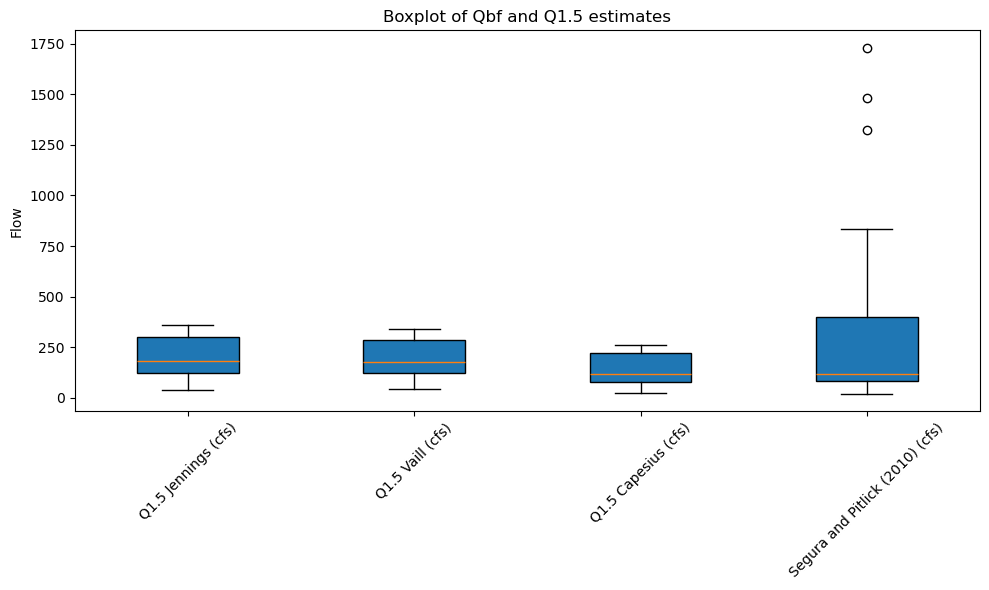

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with Qbf values as strings (including letter annotations)
segura_data = {
    'Qbf': [
        "0.70", "11.6", "9.50", "7.00", "23.6", "14.3", "2.69", "10.5",
        "1.83", "7.00", "20.1", "12.1", "1.12", "1.41", "2.43", "0.58",
        "6.20", "0.84", "2.69", "3.29", "1.04", "2.44", "3.27", "3.22",
        "4.45", "3.17", "2.52", "49.0", "37.5", "42.0", 
    ]
}

segura_df = pd.DataFrame(segura_data)

# Remove non-numeric suffixes from Qbf and convert the column to float.
segura_df['Qbf'] = segura_df['Qbf'].str.extract(r'([\d\.]+)').astype(float)

# Convert from m^3/s to cfs
segura_df['Qbf'] = segura_df['Qbf'] * 35.3147

# Prepare data for the boxplot. The sites DataFrame is assumed to have the following columns:
# 'Q1.5_Jennings (cfs)', 'Q1.5_Vaill (cfs)', 'Q1.5_Capesius (cfs)'
data_to_plot = [
    sites['Q1.5_Jennings (cfs)'].values,
    sites['Q1.5_Vaill (cfs)'].values,
    sites['Q1.5_Capesius (cfs)'].values,
    segura_df['Qbf'].values
]

# Define labels for the boxplot
labels = [
    'Q1.5 Jennings (cfs)',
    'Q1.5 Vaill (cfs)',
    'Q1.5 Capesius (cfs)',
    'Segura and Pitlick (2010) (cfs)'
]

# Create the boxplot with a single call passing in all data arrays.
plt.figure(figsize=(10, 6))
plt.boxplot(data_to_plot, patch_artist=True)
plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
plt.ylabel('Flow')
plt.title('Boxplot of Qbf and Q1.5 estimates')
plt.tight_layout()
plt.show()


**List some bullets describing how you could generate better estimates of Q1.5 and the flow duration curve at these ungaged sites if your project was not located directly upstream of a gage.**

- Regional Regression Analysis: Develop regression models using data from nearby gaged watersheds with similar physiographic and climatic characteristics to better predict Q1.5 and the flow duration curve (FDC).

- Hydrologic Modeling: Calibrate a physically based hydrologic model (e.g., HEC-HMS or SWAT) on gaged watersheds, then transfer calibrated parameters to the ungaged site.

- GIS-based Watershed Characterization: Use high-resolution DEMs and GIS tools to refine watershed delineation and derive detailed geomorphic parameters (e.g., drainage area, slope, stream network topology) that improve flow estimations.

- Field Data Supplementation: Use rating curves developed from pressure transducers or staff guages and game cameras to validate and adjust model outputs.

## Problem 3

 You have been hired by a mining company to provide consulting services on a stream and bot
tomland hardwood forest restoration project. Large sections of Durham Creek near Edwards,
 NC and its adjacent floodplain forests were completely destroyed for phosphate mining, and
 the mining company must now restore the stream, floodplain, and native floodplain vegeta
tion per their CWA Section 404 permit from the USACE. They hired you because you have
 expertise in both stream hydraulics and matching an appropriate hydrologic regime to the
 loodplain plant communities that are targeted for reestablishment. 
 
A nearby USGS streamflow gage collected 29 years of daily streamflow records prior to the
 mine expansion. Your hydrologic analysis indicates that the gage data are representative 
 of current land use and climate characteristics, and provide an excellent representation of the
 hydrologic regime of the stream after is it reestablished. Even more fortunately, there are
 detailed local data on relationships between floodplain plant species and overbank flooding
 frequency (see attached ”Appendix Table 1a”). 
 
Your task is to design a channel that provides the correct frequency of floodplain inundation 
during the growing season that is needed to support a cypress-tupelo forest adjacent to the restored stream. 
This preliminary analysis does not involve any sediment transport analysis. Instead it utilizes previous hydraulic
and sediment modeling and focuses on matching the overbank flooding regime to target tree species.

 Perform the following steps in your analysis:
 
 - USGS 02084540 DURHAM CREEK AT EDWARD, 1965-09-01 - 1994-08-31.
 - Write a formula  that allows you to separate out the 29 year record
 of growing season discharge data from the entire period of record. The growing season
 may be approximated as April 1–Oct. 31.
 
 - Develop a cumulative distribution function (CDF) or flow duration curve of growing
 season flows using either a ranking/plotting position approach or the histogram tool
 in Excel. If you use the histogram tool, it is recommended that you set up 25 arithmetic
 bins at an interval of 0.8 cfs from 0 to 20 cfs.

 - Now the fun part: use the Manning equation to develop a preliminary design of a
 channel that provides the correct frequency of floodplain inundation during to growing
 season to support a cypress-tupelo forest. Use the data from the attached table (”Ap
pendix Table 1a”) to identify the average growing season flood frequency in the first
 two increments of elevation (2.46 m and 2.61 m). Make this average value your target
 for the preliminary design. Assume a rectangular channel (the soil is extremely clayey
 and cohesive and stable vertical banks are observed in the field), a water surface slope
 of 0.0005, and a Manning n value of 0.12 based on the gradient, anticipated extent
 of woody debris and sinuosity, and measurements at nearby reference sites. Based on
 reference sites you have also determined the width to depth ratio of the channel equals
 3.0.

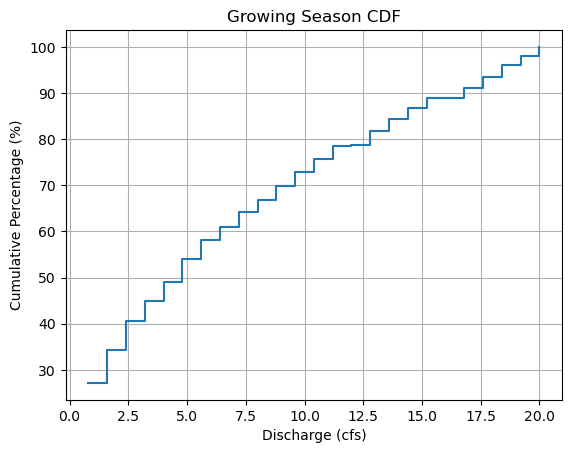

Target discharge (Q_target) based on a 41.5% flood frequency: 14.0 cfs


In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

# Define the file path to the Excel file.
excel_path = r"C:\Users\adunw\OneDrive - Colostate\Fort Collins\Courses\Spring 2025\CIVE 613 - River Restoration\HW 2\Q3 Durham Creek.xlsx"

# Read the Excel file into a pandas DataFrame.
df = pd.read_excel(excel_path)

# Convert the 'datetime' column to datetime objects.
df['datetime'] = pd.to_datetime(df['datetime'])

# Filter the data for the growing season (April 1 – October 31).
# Note: Filtering by month (4 <= month <= 10) approximates the growing season.
df_gs = df[(df['datetime'].dt.month >= 4) & (df['datetime'].dt.month <= 10)]

# Extract the discharge data (in cfs) for the growing season.
discharge_gs = df_gs['Discharge (cfs)']

# ----- Step 1: Flow Duration Curve via Histogram -----

# Set up 25 arithmetic bins from 0 to 20 cfs (interval = 0.8 cfs).
bins = np.arange(0, 20.0 + 0.8, 0.8)
hist, bin_edges = np.histogram(discharge_gs, bins=bins)

# Compute cumulative frequency (as a cumulative percentage).
cum_hist = np.cumsum(hist)       # Calculate the cumulative sum of the frequency counts in each bin.

# Convert the cumulative counts to percentages by dividing by the total count (last element of cum_hist) and multiplying by 100.
cum_perc = 100 * cum_hist / cum_hist[-1]  

# Plot the flow duration curve (CDF).
plt.figure()
plt.step(bin_edges[1:], cum_perc, where='post')
plt.xlabel('Discharge (cfs)')
plt.ylabel('Cumulative Percentage (%)')
plt.title('Growing Season CDF')
plt.grid(True)
plt.show()

# ----- Step 2: Determine Target Design Flow -----

# Given:
#   - Flood frequency at 2.46 m elevation = 56%
#   - Flood frequency at 2.61 m elevation = 27%
# The target (average) flood frequency for design:
target_flood_frequency = (56 + 27) / 2.0  # equals 41.5%
# For a flow duration curve where the y-axis represents the percentage of time that flows are equal to or exceeded,
# a target flood frequency of 41.5% corresponds to a discharge that is equaled or exceeded 41.5% of the time.
# In a cumulative distribution (percentage of data below a given discharge), this is the 100 - 41.5 = 58.5th percentile.
Q_target = np.percentile(discharge_gs, 100 - target_flood_frequency)
print("Target discharge (Q_target) based on a 41.5% flood frequency:", Q_target, "cfs")

# ----- Step 3: Channel Design Using Manning's Equation -----

# For a rectangular channel with a width-to-depth ratio of 3.0:
#   Let d = channel depth (m), then width = 3*d.
#   Cross-sectional area, A = width * d 
#   Wetted perimeter, P = width + 2*d 
#   Hydraulic radius, R = A / P 
#
# Manning's equation:
#   Q = (1/n) * A * (R^(2/3)) * (S^(1/2))
#
# where:
#   - n = Manning’s roughness coefficient (0.12),
#   - S = water surface slope (0.0005).

n = 0.12
S = 0.0005

def Q_manning(d):
    """Compute discharge (cfs) through a rectangular channel of depth d (m)
    using the Manning equation."""
    width = 3 * d        # channel width (m)
    A = width * d        # cross-sectional area (m^2)
    P = width + 2 * d    # wetted perimeter (m)
    R = A / P
    return (1/n) * A * (R**(2/3)) * (S**0.5)

# Solve for the channel depth 'd' such that Q_manning(d) equals Q_target.
d_initial_guess = 1.0  # initial guess for the channel depth in meters
design_depth = fsolve(lambda d: Q_manning(d) - Q_target, x0=[d_initial_guess])[0]
design_width = 3 * design_depth


#### **1. Why do we focus on the growing season when matching floodplain vegetation to an appropriate hydrologic regime?**

During the growing season, vegetation is actively establishing and growing, and its water needs are most critical. Matching the hydrologic regime during this period ensures that the frequency and magnitude of flows meet the ecological requirements for seed germination, growth, and nutrient uptake.

#### **2. Provide a plot of the flow frequency distribution from your analysis.**


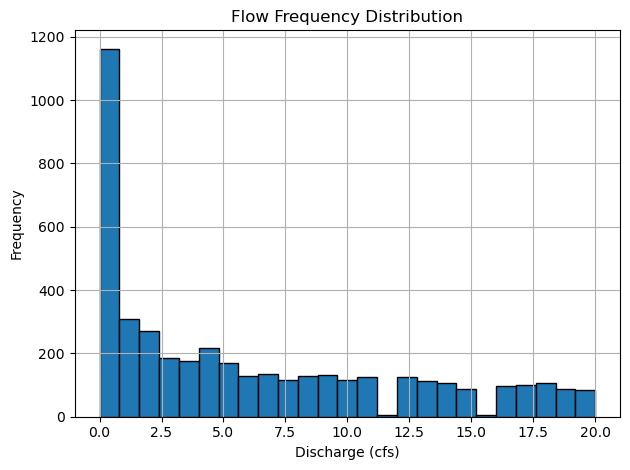

In [9]:
# Create a single figure no subplot
fig, axs = plt.subplots()

# Calculate bin centers for plotting.
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
axs.bar(bin_centers, hist, width=0.8, align='center', edgecolor='black')
axs.set_xlabel('Discharge (cfs)')
axs.set_ylabel('Frequency')
axs.set_title('Flow Frequency Distribution')
axs.grid(True)

plt.tight_layout()
plt.show()

#### **3. Are the frequencies you‘re presenting exceedence or non-exceedence probabilities? Define the difference.**

The plot produced by my code shows a non-exceedence probability curve, or the cumulative percentage of time that the flow is less than or equal to each discharge value.

Non-Exceedence Probability:

- For each discharge value, the curve indicates the percentage of time the actual flow is below or equal to that value. For instance, if the curve shows 70% at 8 cfs, it means that 70% of the growing season observations have flows at or below 8 cfs.

Exceedence Probability:

- This is the percentage of time that the discharge exceeds a given value. It is calculated as 100% minus the non-exceedence probability. So if 70% is the non-exceedence probability at 8 cfs, then the exceedence probability is 30%.

#### **4. The project is aimed at establishing a growing season hydrologic regime next to the channel that is appropriate for baldcypress and water tupelo. What are the scientific names of these two species? In which elevation increments do they predominantly coexist?**

The scientific name for baldcypress is Taxodium distichum, and for water tupelo is Nyssa aquatica. The elevation range of baldcypress is 2.72m +/- 0.12 and for water tupelo is 2.83m +/- 0.17, so they coexist in the elevation range of 2.66m - 2.84m.

#### **5. What growing season flooding frequency are you targeting?**

 41.6% 

 #### **6. What are the preliminary design width and depth of the channel in meters? Clearly explain and show your formulas and design approach.**


**Preliminary Channel Design**

The design process is based on solving the hydraulic equations that govern open channel flow. 

1. **Manning’s Equation:**

   $$Q = \frac{1}{n} A R^{2/3} S^{1/2}$$

   In this equation:
   - $n$ is Manning’s roughness coefficient,
   - $A$ is the cross‐sectional area,
     - $A = d \times w$
   - $R$ is the hydraulic radius 
     - $ R = \frac{A}{P} $
   - $S$ is the channel slope,
   - $P$ is the wetted perimeter. For a rectangular channel
     - $P = w + 2d$.

**Design Approach:**

- The target discharge $Q_{\text{target}}$ is determined from the flow duration curve.
- We have an equation with one unknown variable, depth,  that we can optimize for: $Q_{manning}$ - $Q_{\text{target}}$ = 0.
- The resulting system of equations is solved numerically using the `fsolve` function to obtain the design values.

The numerical solution of these equations provides the design channel width and depth.



In [4]:
print(f"Design depth: {design_depth:.2f} m")
print(f"Design width: {design_width:.2f} m")

Design depth: 3.80 m
Design width: 11.41 m


#### **7. How could you use the Appendix Table 1a above to shape the floodplain in a manner that maximizes the potential for species richness and regeneration of a diverse assemblage of plant species**

You could expand the analysis above to make sure the design channel/floodplain result in a flooding frequency during the growing season that corresponds reasonable well with the observed "% growing season flooding frequency" across all elevation increments. In our analysis, we just took an average of the first two increments % growing season flooding frequencies and used a simple continuity/manning equation approach to find the design width and depth, but in a real design scenario you could iteratively design the channel, using a 2D hydraulic model to align each of the elevation increments with their ideal "% growing season flooding frequency". 


